In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F


from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr = 2e-4 #vary 
img_dim = 64
channels_img = 3
batch_size = 128
z_dim=100
num_epochs = 20

In [3]:
transforms = transforms.Compose(
    [
        transforms.Resize(img_dim),
        transforms.CenterCrop(img_dim),# Required as Images are of different size
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]),     
    ]
) 

In [4]:
dataset = datasets.ImageFolder(root="/kaggle/input/", transform = transforms)
loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [6]:
class Generator(nn.Module):
    def __init__(self, noise_dim, channels):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            
            nn.ConvTranspose2d(noise_dim, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)

In [7]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [8]:
disc = Discriminator(channels_img).to(device)
gen = Generator(z_dim, channels_img).to(device)

In [9]:
initialize_weights(disc)
initialize_weights(gen)

opt_disc = optim.Adam(disc.parameters(), lr = lr, betas=(0.5,0.999))
opt_gen = optim.Adam(gen.parameters(), lr = lr, betas=(0.5,0.999))

criterion = nn.BCELoss()

In [10]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [11]:
fixed_noise = torch.randn((32, z_dim, 1, 1)).to(device)

In [12]:
def show(imgs): #Show function from pytorch.org
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [13]:
def train_disc(real_img, fake_img, optim):

    optim.zero_grad()

    #Discriminator max log(D(real)) + log(1 - D(G(z)))

    disc_real = disc(real_img).reshape(-1)
    loss_real = criterion(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake_img).reshape(-1)# detach for generator stuff or a
    loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    loss_D = (loss_real + loss_fake)/2

    loss_D.backward()
    
    opt_disc.step()

    return loss_D

def train_gen(fake_img, optim):

    optim.zero_grad()
    
    #Discriminator min log(1 - D(G(z))) but better to max log(D(G(z)))
    output = disc(fake_img).reshape(-1)
    loss_G = criterion(output, torch.ones_like(output))

    loss_G.backward()

    opt_gen.step()

    return loss_G

Epoch [0/20] Batch 0/497 Discriminator loss: 0.6909, Generator loss: 0.7299
Epoch [1/20] Batch 0/497 Discriminator loss: 0.8009, Generator loss: 3.6613
Epoch [2/20] Batch 0/497 Discriminator loss: 0.5418, Generator loss: 2.3936
Epoch [3/20] Batch 0/497 Discriminator loss: 0.7190, Generator loss: 1.7695
Epoch [4/20] Batch 0/497 Discriminator loss: 0.4169, Generator loss: 3.0423
Epoch [5/20] Batch 0/497 Discriminator loss: 0.4326, Generator loss: 2.1828
Epoch [6/20] Batch 0/497 Discriminator loss: 0.5853, Generator loss: 6.2140
Epoch [7/20] Batch 0/497 Discriminator loss: 0.2978, Generator loss: 2.1218
Epoch [8/20] Batch 0/497 Discriminator loss: 0.4143, Generator loss: 2.5041
Epoch [9/20] Batch 0/497 Discriminator loss: 0.2607, Generator loss: 2.1806
Epoch [10/20] Batch 0/497 Discriminator loss: 0.3792, Generator loss: 4.2953
Epoch [11/20] Batch 0/497 Discriminator loss: 0.3657, Generator loss: 1.9676
Epoch [12/20] Batch 0/497 Discriminator loss: 0.3658, Generator loss: 3.7678
Epoch [13

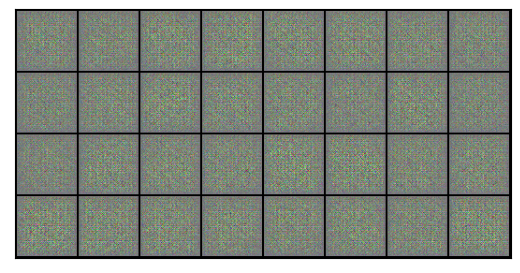

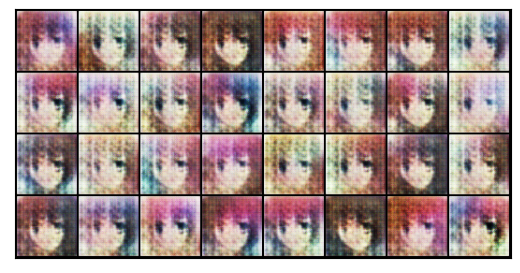

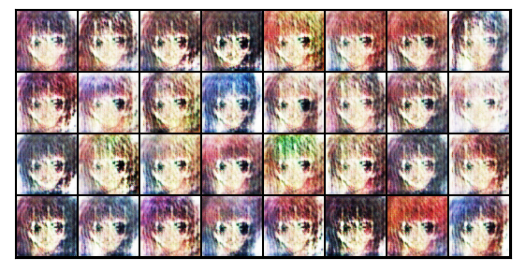

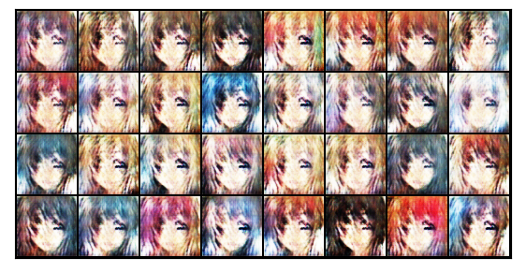

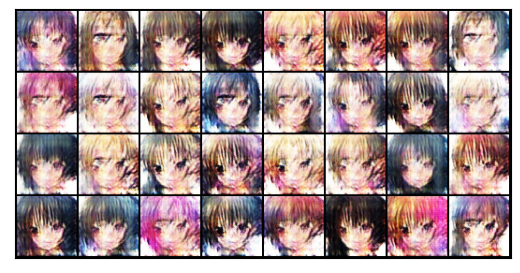

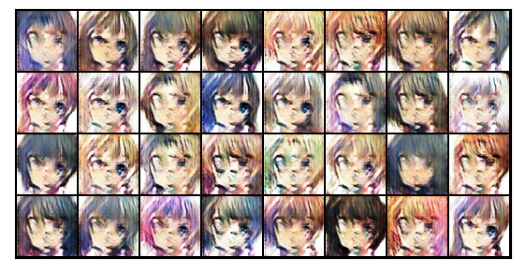

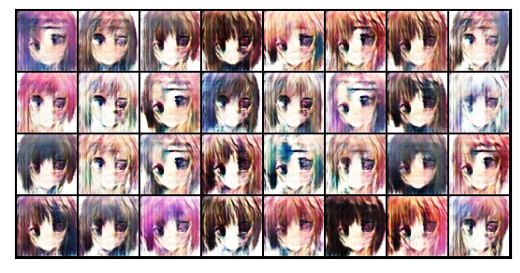

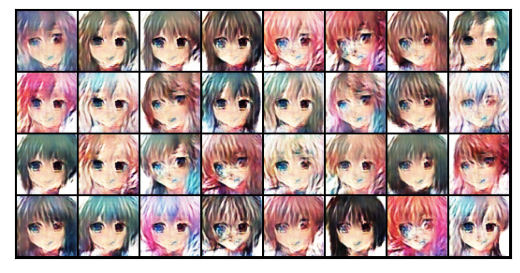

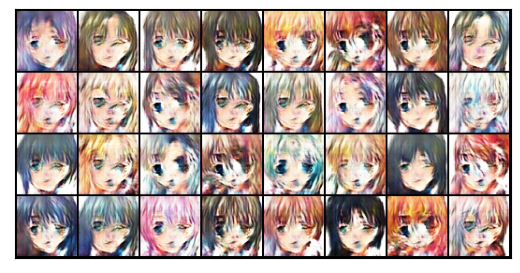

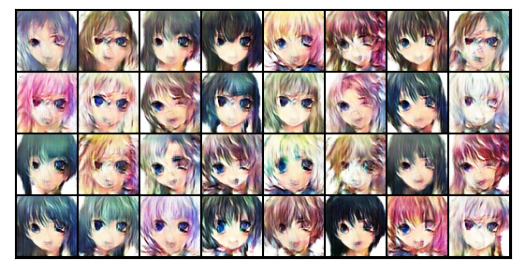

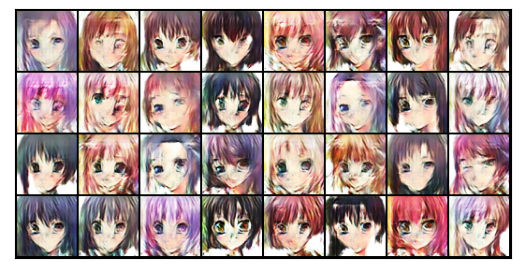

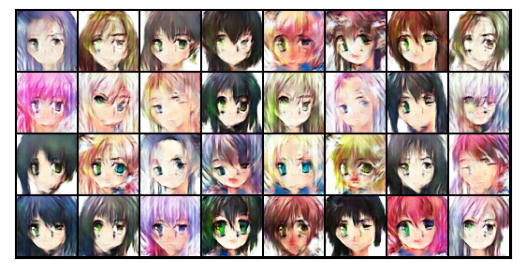

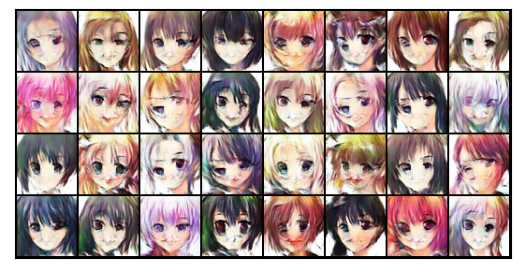

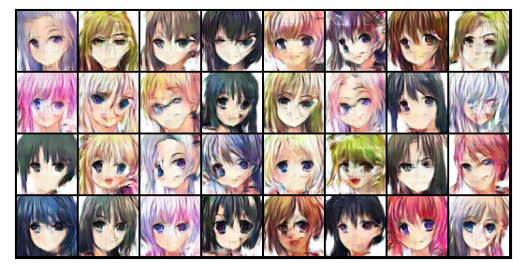

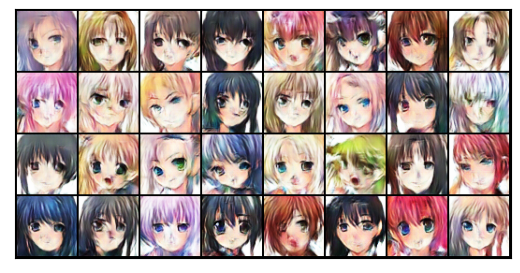

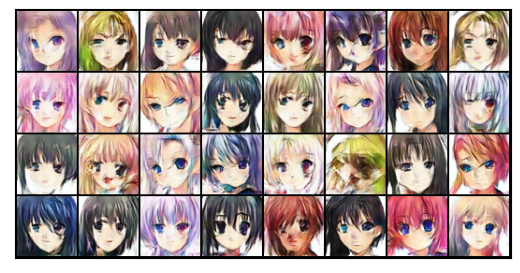

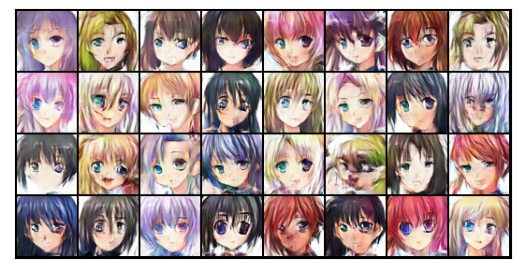

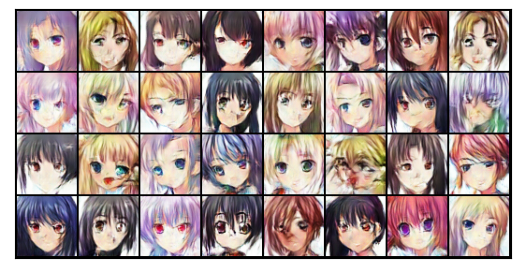

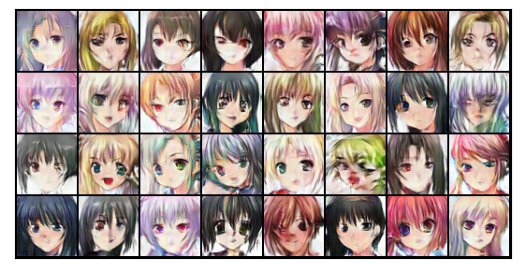

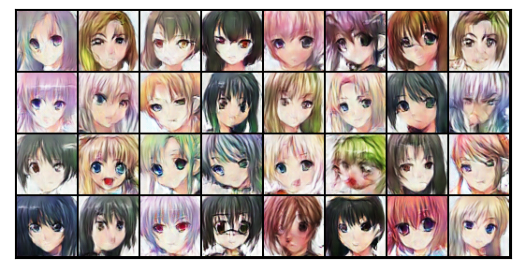

In [14]:
losses_g = []
losses_d = []

for epoch in range(num_epochs):

    loss_d = 0.0
    loss_g = 0.0

    for batch_idx, (real, _) in enumerate(loader):

        real = real.to(device)
        batch_size = real.shape[0]


        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise).detach()

        loss_d = train_disc(real, fake, opt_disc)
        losses_d.append(loss_d.detach().cpu())


        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise)

        loss_g = train_gen(fake, opt_gen)
        losses_g.append(loss_g.detach().cpu())

###################################################
        if batch_idx == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} Discriminator loss: {loss_d:.4f}, Generator loss: {loss_g:.4f}")

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, channels_img, img_dim, img_dim)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                show(img_grid_fake)
####################################################

In [15]:
fake = gen(noise).reshape(-1, channels_img, img_dim, img_dim)
img_grid = torchvision.utils.make_grid(fake, normalize=True)
save_image(img_grid, "interpolation.png")

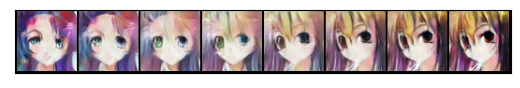

In [16]:
point_1 = torch.randn((1, z_dim, 1, 1)).to(device)
point_2 = torch.randn((1, z_dim, 1, 1)).to(device)

interpolated = point_1.detach().clone()
for i in range(1, 8, 1):
    inter = torch.lerp(point_1, point_2,(i/7.0)).to(device)
    interpolated = torch.cat((interpolated, inter), 0).to(device)
    
fake = gen(interpolated).reshape(-1, channels_img, img_dim, img_dim)
img_grid_interpolated = torchvision.utils.make_grid(fake, normalize=True)
show(img_grid_interpolated)

save_image(img_grid_interpolated, "interpolation.png")

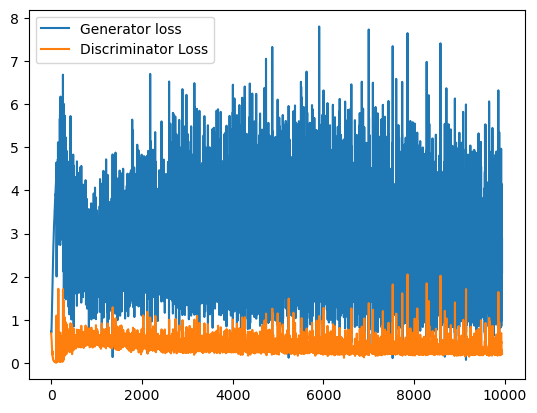

In [17]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig("loss.png")
plt.show()